In [1]:
from sklearn.cluster import KMeans
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
from numpy import inf

from __future__ import division
import numpy as np
from sklearn import  preprocessing
from sklearn.metrics import roc_auc_score
# import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


USE_PARTIAL_DATA = True
SEED = 12
BLOCK_SIZE = 10
N_CLUSTERS = 8

USE_ORIGINAL = False

/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def extract_wave(filename):
    print "loading data..."

    data = spio.loadmat(filename, squeeze_me=True)

    print "data loaded"

    #I_AC_ALL contains reflection information matrix and the freqs that were measures
    matrix = data['I_AC_ALL']
    freq = data['sfx']
    print freq

    matrix = np.asarray(matrix)

    #matrix indices are (x,y,color,freq)

    #Work with just the first color for now
    wave = matrix[:,:,0,:]
    
    if USE_PARTIAL_DATA:
        wave = wave[200:300,200:300,:]

    #plot an example image at just one frequency
    image = wave[:,:,4]
    plt.imshow(image)
    plt.show()
    
    return wave, freq


In [3]:
def remove_infs(x):
    x[x == -inf] = 0
    x[x == inf] = 0
    x[np.isnan(x)] = 0
    return x

In [4]:
#Do some feature engineering

def find_power_law(ydatas, xdata):
    amps = np.zeros((ydatas.shape[0],1))
    indexs = np.zeros((ydatas.shape[0],1))
    i = 0
    for ydata in ydatas:
        logx = np.log10(xdata)
        logy = np.log10(ydata)

        pfinal = np.polyfit(logx,logy,1)

        index = pfinal[0]
        amp = 10.0**pfinal[1]

        amps[i][0] = amp
        indexs[i][0] = index

        i += 1
        
    return amps, indexs

def augment(cancer, freq): 
    amps_cancer, indexs_cancer = find_power_law(cancer, freq)

    if USE_ORIGINAL:
        cancer = np.hstack((cancer,amps_cancer,indexs_cancer))
    else:
        cancer = np.hstack((amps_cancer,indexs_cancer))

    cancer = remove_infs(cancer)
    
    return cancer

In [5]:
def make_cluster(cancer_wave, cancer):
    n, m, _ = cancer_wave.shape

#     special_features = np.hstack((amps_cancer,indexs_cancer))
#     special_features = remove_infs(special_features)

    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(cancer)

    new_image = kmeans.labels_.reshape((n,m))

    plt.imshow(new_image)
    plt.colorbar()
    plt.show()
    return kmeans

loading data...
data loaded
[ 1.2794      1.23022306  1.18104367  1.13180875  1.0825557   1.03339383
  0.98417845  0.93497537  0.88574953  0.83653077  0.78734276  0.73814537
  0.68892922  0.63972599]


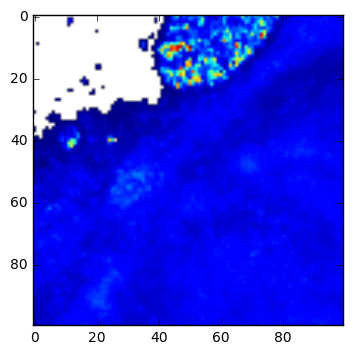

/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


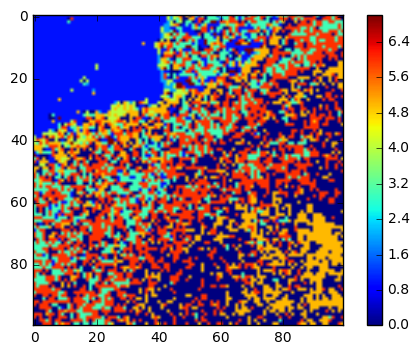

loading data...
data loaded
[ 1.2794      1.23022306  1.18104367  1.13180875  1.0825557   1.03339383
  0.98417845  0.93497537  0.88574953  0.83653077  0.78734276  0.73814537
  0.68892922  0.63972599]


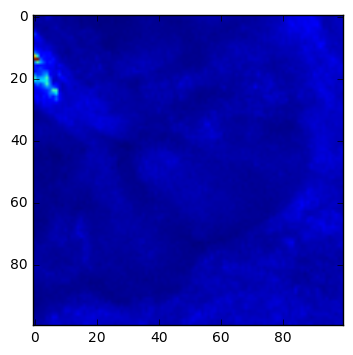

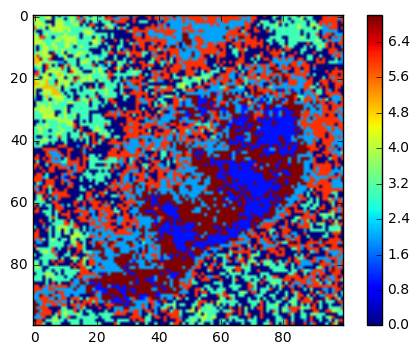

In [6]:
def process_wave(filename):
    cancer_wave, freq = extract_wave(filename)
    cancer_wave = remove_infs(cancer_wave)
    cancer = cancer_wave.reshape((cancer_wave.shape[0] * cancer_wave.shape[1], cancer_wave.shape[2]))
    cancer = augment(cancer,freq)
    cancer_kmeans = make_cluster(cancer_wave, cancer)
    return cancer_kmeans, cancer, cancer_wave

cancer_kmeans, cancer_features, cancer_wave = process_wave('data/I_AC_ALL0a.mat')
normal_kmeans, normal_features, normal_wave = process_wave('data/I_AC_ALL0b.mat')


In [7]:
def find_background(kmeans):
    
    background = 0

    for i in range(len(kmeans.cluster_centers_)):
        if(kmeans.cluster_centers_[i][1] < kmeans.cluster_centers_[background][1]):
            background = i

    return background

def prepare_dataset(cancer_kmeans, cancer_numbers, background_cancer):
    y_cancer = np.zeros((N_CLUSTERS,1))
    for i in cancer_numbers:
        y_cancer[i][0] = 1    

    np.delete(y_cancer,background_cancer,0)
    X_cancer = cancer_kmeans.cluster_centers_
    np.delete(X_cancer,background_cancer,0)
    
    return X_cancer, y_cancer


cancer_numbers = [1, 6]
background_cancer = 2

X_cancer, y_cancer = prepare_dataset(cancer_kmeans, cancer_numbers, background_cancer)
X_normal, y_normal = prepare_dataset(normal_kmeans, [], 0)

X = np.vstack((X_cancer,X_normal))
y = np.vstack((y_cancer,y_normal))

In [8]:
"""
Fit models and make predictions.
We'll use one-hot encoding to transform our categorical features
into binary features.
y and X will be numpy array objects.
"""

def bagged_set(X_t,y_c,model, myseed, estimators, xt, update_seed=True):
    
    # create array object to hold predictions 
    baggedpred=[ 0.0  for d in range(0, (xt.shape[0]))]
    #loop for as many times as we want bags
    for n in range (0, estimators):
        #shuff;e first, aids in increasing variance and forces different results
        #X_t,y_c=shuffle(Xs,ys, random_state=seed+n)

        if update_seed: # update seed if requested, to give a slightly different model
            model.set_params(seed=myseed + n)
        model.fit(X_t,y_c) # fit model0.0917411475506
        preds=model.predict_proba(xt)[:,1] # predict probabilities
        # update bag's array

        baggedpred+=preds
    # divide with number of bags to create an average estimate            

    baggedpred = np.true_divide(baggedpred,float(estimators))
    # return probabilities            
    return np.array(baggedpred) 

filename="LR" # nam prefix
#model = linear_model.LogisticRegression(C=3)  # the classifier we'll use

model=RandomForestClassifier(random_state=0)




# if USE_PARTIAL_DATA == 1:
#     X, X_discard, y, y_discard = train_test_split(X, y, train_size=PERCENT_DATA, random_state=42)




#create arrays to hold cv an dtest predictions
train_stacker=[ 0.0  for k in range (0,(X.shape[0])) ] 

# === training & metrics === #
mean_auc = 0.0
bagging=5 # number of models trained with different seeds
n = 2  # number of folds in strattified cv

c, r = y.shape
y = y.reshape(c,)

kfolder=StratifiedKFold(y, n_folds= n,shuffle=True, random_state=SEED)     
i=0
for train_index, test_index in kfolder: # for each train and test pair of indices in the kfolder object
    # creaning and validation sets
    X_train, X_cv = X[train_index], X[test_index]
    y_train, y_cv = np.array(y)[train_index], np.array(y)[test_index]
    #print (" train size: %d. test size: %d, cols: %d " % ((X_train.shape[0]) ,(X_cv.shape[0]) ,(X_train.shape[1]) ))

    # if you want to perform feature selection / hyperparameter
    # optimization, this is where you want to do it

    # train model and make predictions 
    #preds=bagged_set(X_train,y_train,model, SEED , bagging, X_cv, update_seed=False)
    
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_cv)[:,1]


    # compute AUC metric for this CV fold
    roc_auc = roc_auc_score(y_cv, preds)
    print "AUC (fold %d/%d): %f" % (i + 1, n, roc_auc)
    mean_auc += roc_auc

    no=0
    for real_index in test_index:
             train_stacker[real_index]=(preds[no])
             no+=1
    i+=1

AUC (fold 1/2): 0.642857
AUC (fold 2/2): 0.357143


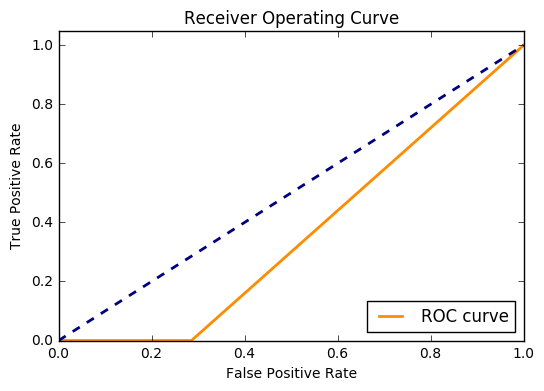

 Average AUC: 0.500000


In [9]:
fpr, tpr, _ = roc_curve(y_cv, preds)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()
    
    
mean_auc/=n
print (" Average AUC: %f" % (mean_auc) )
# print (" printing train datasets ")
# printfilcsve(np.array(train_stacker), filename + ".train.csv")          

In [10]:
# === Predictions === #
# When making predictions, retrain the model on the whole training set
model.fit(X,y)

training_error = roc_auc_score(y, model.predict_proba(X)[:,1])

print training_error

1.0


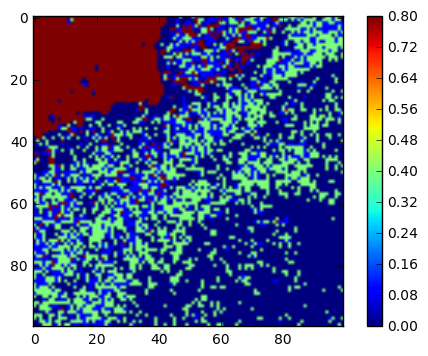

In [11]:
X_test = cancer_kmeans.cluster_centers_

cluster_preds = model.predict_proba(X_test)[:,1]
labels = cancer_kmeans.labels_

pred_map = {}


for i, pred in enumerate(cluster_preds):
    pred_map[i] = pred
    
    
preds = np.ones((len(labels),1))

background = 2

for i, label in enumerate(labels):
    if label == background:
        preds[i][0] = 0
    else:
        preds[i][0] = pred_map[label]

#Put them in a displayable format

n, m, _ = cancer_wave.shape

heatmap = preds.reshape((n,m))
# heatmap = np.clip(heatmap, 0, 0.06)
plt.imshow(heatmap)
plt.colorbar()
plt.show()

loading data...
data loaded
[ 1.35        1.29999448  1.24999355  1.19999563  1.14999267  1.09999399
  1.04999522  0.99999636  0.9499951   0.89999508  0.84999587  0.79999903
  0.74999727  0.6999983   0.54999883  0.49999818]


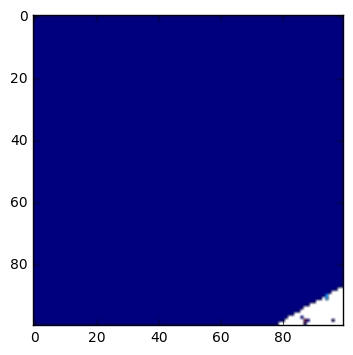

/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


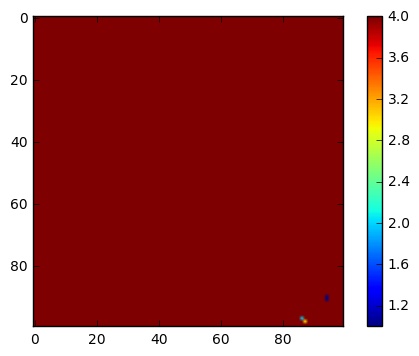

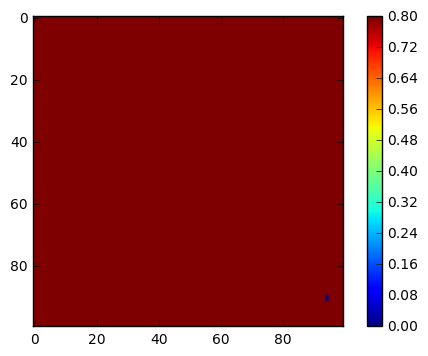

In [12]:
#NEW SAMPLE
cancer_kmeans, cancer_features, cancer_wave = process_wave('data/I_AC_ALL1.mat')

X_test = cancer_kmeans.cluster_centers_

cluster_preds = model.predict_proba(X_test)[:,1]
labels = cancer_kmeans.labels_

pred_map = {}


for i, pred in enumerate(cluster_preds):
    pred_map[i] = pred
    
    
preds = np.ones((len(labels),1))

# background = find_background(cancer_kmeans)

background = 1

for i, label in enumerate(labels):
    if label == background:
        preds[i][0] = 0
    else:
        preds[i][0] = pred_map[label]
        
#Put them in a displayable format

n, m, _ = cancer_wave.shape

heatmap = preds.reshape((n,m))
# heatmap = np.clip(heatmap, 0, 0.06)
plt.imshow(heatmap)
plt.colorbar()
plt.show()

loading data...
data loaded
[ 1.2794      1.23022306  1.18104367  1.13180875  1.0825557   1.03339383
  0.98417845  0.93497537  0.88574953  0.83653077  0.78734276  0.73814537
  0.68892922  0.63972599]


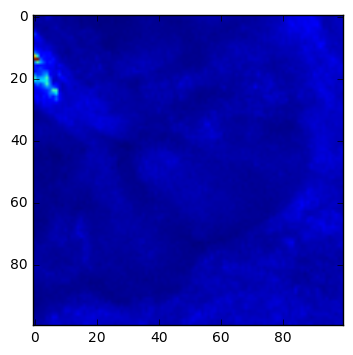

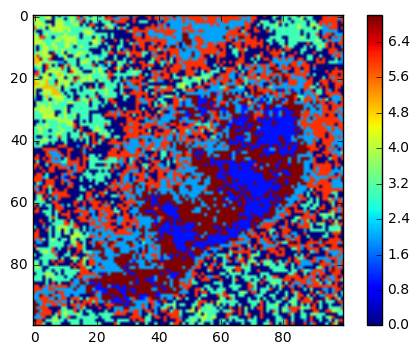

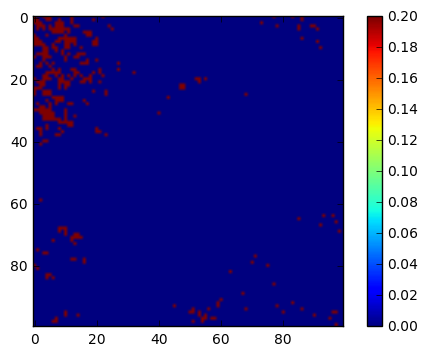

In [13]:
#NEW SAMPLE
cancer_kmeans, cancer_features, cancer_wave = process_wave('data/I_AC_ALL0b.mat')

X_test = cancer_kmeans.cluster_centers_

cluster_preds = model.predict_proba(X_test)[:,1]
labels = cancer_kmeans.labels_

pred_map = {}


for i, pred in enumerate(cluster_preds):
    pred_map[i] = pred
    
    
preds = np.ones((len(labels),1))

# background = find_background(cancer_kmeans)

background = 0

for i, label in enumerate(labels):
    if label == background:
        preds[i][0] = 0
    else:
        preds[i][0] = pred_map[label]
        
#Put them in a displayable format

n, m, _ = cancer_wave.shape

heatmap = preds.reshape((n,m))
# heatmap = np.clip(heatmap, 0, 0.06)
plt.imshow(heatmap)
plt.colorbar()
plt.show()

loading data...
data loaded
[ 1.35        1.29999448  1.24999355  1.19999563  1.14999267  1.09999399
  1.04999522  0.99999636  0.9499951   0.89999508  0.84999587  0.79999903
  0.74999727  0.6999983   0.54999883  0.49999818]


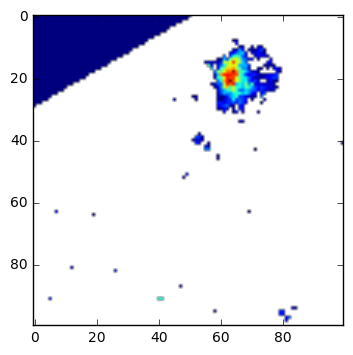

/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


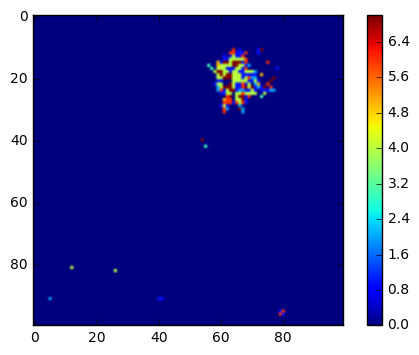

In [14]:
#NEW SAMPLE
cancer_kmeans, cancer_features, cancer_wave = process_wave('data/I_AC_ALL2.mat')

X_test = cancer_kmeans.cluster_centers_

cluster_preds = model.predict_proba(X_test)[:,1]
labels = cancer_kmeans.labels_

pred_map = {}


for i, pred in enumerate(cluster_preds):
    pred_map[i] = pred
    
    
preds = np.ones((len(labels),1))

# background = find_background(cancer_kmeans)
background = 0

for i, label in enumerate(labels):
    if label == background:
        preds[i][0] = 0
    else:
        preds[i][0] = pred_map[label]

In [15]:
# #Find the predictions
# test_matrix = remove_infs(cancer_wave)
# X_test = test_matrix.reshape((test_matrix.shape[0] * test_matrix.shape[1], test_matrix.shape[2]))

# #Do some feature engineering
# amps_test, indexs_test = find_power_law(X_test, freq)

# if USE_ORIGINAL:
#     X_test = np.hstack((X_test, amps_test, indexs_test))
# else:
#     X_test = np.hstack((amps,indexs))
# X_test = remove_infs(X_test)

# preds = model.predict_proba(X_test)[:,1]

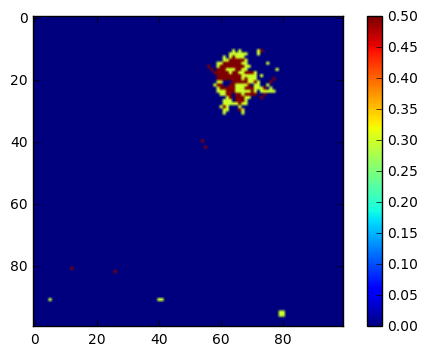

In [16]:
#Put them in a displayable format

n, m, _ = cancer_wave.shape

heatmap = preds.reshape((n,m))
# heatmap = np.clip(heatmap, 0, 0.06)
plt.imshow(heatmap)
plt.colorbar()
plt.show()